In [33]:
# The new function with the parameters is at the bottom. It's called new_train_and_show_scores 

In [16]:
import pandas as pd

In [17]:
# Read in the training and test datasets from previously created csv files

imdb_train = pd.read_csv('csv/imdb_train.csv')
imdb_test = pd.read_csv('csv/imdb_test.csv')

In [18]:
# Display information and first few entries from the training and test datasets

pd.set_option('display.max_colwidth', None)

print ("----- Training dataset Info:")
imdb_train.info(verbose=None, buf=None, max_cols=None, memory_usage=None, null_counts=None)
print ("Training dataset Content:")
print(imdb_train.iloc[:5])

print ("\n----- Test dataset Info:")
imdb_test.info(verbose=None, buf=None, max_cols=None, memory_usage=None, null_counts=None)
print ("Test dataset Content:")
print(imdb_test.iloc[:5])

----- Training dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
Training dataset Content:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [20]:
# Create a bigram vectorizer and process the training set to generate a list of bigrams. 
# Note that bigram processing is set via the ngram_range parameter and so includes unigrams and bigrams

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(imdb_train['text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [21]:
# Display the length and a few samples of the bigram vectorizer to show the bigrams that have been extracted

print("Number of bigrams found:", len(bigram_vectorizer.get_feature_names()))
print(bigram_vectorizer.get_feature_names()[10000:10100])
print(bigram_vectorizer.get_feature_names()[50000:50100])

Number of bigrams found: 1520266
['3am but', '3am invesment', '3am it', '3am taped', '3bs', '3bs who', '3d', '3d adventure', '3d although', '3d and', '3d animated', '3d animation', '3d animations', '3d animators', '3d artists', '3d assante', '3d bird', '3d bore', '3d capabilities', '3d cg', '3d cgi', '3d character', '3d companies', '3d computer', '3d dept', '3d disgrace', '3d effect', '3d effects', '3d element', '3d ending', '3d environment', '3d especially', '3d feel', '3d game', '3d games', '3d glasses', '3d grafics', '3d graphics', '3d gravity', '3d had', '3d imax', '3d in', '3d it', '3d just', '3d mario', '3d models', '3d movie', '3d movies', '3d panoramic', '3d plat', '3d probably', '3d programs', '3d sequence', '3d shoot', '3d shooter', '3d shooters', '3d special', '3d splatter', '3d technology', '3d that', '3d trust', '3d was', '3d wave', '3d well', '3d which', '3d with', '3d world', '3d wow', '3dvd', '3dvd collection', '3k', '3k all', '3k attack', '3k but', '3k if', '3k it', '3

In [22]:
# Now generate bigram statistics on the training set

X_train_bigram = bigram_vectorizer.transform(imdb_train['text'].values)

In [23]:
# Display the attributes the bigram count matrix; notice it is really huge with 25000 rows since we have 25000 entries
# in the training dataset and 1520266 columns since we saw above that we have 1520266 bigrams

print(repr(X_train_bigram))

<25000x1520266 sparse matrix of type '<class 'numpy.int64'>'
	with 8689547 stored elements in Compressed Sparse Row format>


In [24]:
# Create a bigram tf-idf vectorizer and load the training set using the bigram count matrix from earlier

bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [25]:
# Now calculate the bigram tf-idf statistics

X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

In [26]:
# Display the attributes the bigram tf-idf matrix; it should be the same size as the bigram matrix above

print(repr(X_train_bigram_tf_idf))

<25000x1520266 sparse matrix of type '<class 'numpy.float64'>'
	with 8689547 stored elements in Compressed Sparse Row format>


In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple

In [28]:
# Helper function to display confusion matrix

def display_confusion_matrix(y_true, y_pred) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
    plt.show()
    

In [29]:
# This is the new function with the parameters

def new_train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> Tuple[float, float]:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier(loss="squared_hinge",penalty="l2",learning_rate="optimal")
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')
    
    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_valid)
    print(f'Train precision: {round(precision_score(y_train, train_pred), 2)} ; Validation precision: {round(precision_score(y_valid, valid_pred), 2)}')
    print(f'Train recall: {round(recall_score(y_train, train_pred), 2)} ; Validation recall: {round(recall_score(y_valid, valid_pred), 2)}')
    print(f'Train F1: {round(f1_score(y_train, train_pred), 2)} ; Validation F1: {round(f1_score(y_valid, valid_pred), 2)}')
    print("Train Confusion Matrix: ")
    print(confusion_matrix(y_train, train_pred))
    display_confusion_matrix(y_train, train_pred)
    print("Validation Confusion Matrix: ")
    print(confusion_matrix(y_valid, valid_pred))
    display_confusion_matrix(y_valid, valid_pred)
    print("\n")
    
    return train_score, valid_score, clf

In [30]:
y_train = imdb_train['label'].values

----- Bigram Tf-Idf -----
Train score: 1.0 ; Validation score: 0.9
Train precision: 1.0 ; Validation precision: 0.89
Train recall: 1.0 ; Validation recall: 0.92
Train F1: 1.0 ; Validation F1: 0.9
Train Confusion Matrix: 
[[9370    5]
 [   4 9371]]


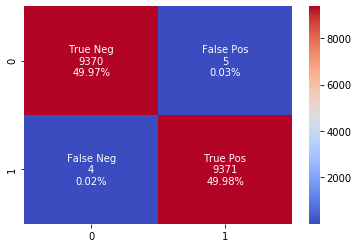

Validation Confusion Matrix: 
[[2757  368]
 [ 249 2876]]


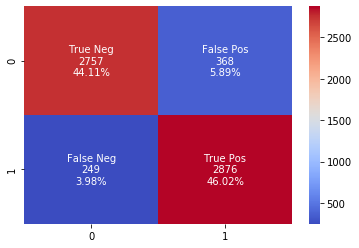

In [32]:
btfidf_train_score, btfidf_valid_score, btfidf_clf = new_train_and_show_scores(X_train_bigram_tf_idf, y_train, '----- Bigram Tf-Idf -----')